In [1]:
!pip install mord

Accuracy: 0.6430317848410758
Odds Ratios:
Age : 1.1656820142651971
BMD : 0.24093341100447155
T Score : 0.7452131877392195
Vit D : 0.9605606575845649
Calcium : 1.2582924178777204
Gender_F : 0.8892114714625549
Gender_M : 1.1245917072477836
DM_No : 1.0467953419505693
DM_Pre : 0.9595419169105279
DM_Unavailable : 1.1187740795596937
DM_Yes : 0.8898807350601404
HTN_No : 1.043684952334295
HTN_Unavailable : 0.7763512011384556
HTN_Yes : 1.2341623181815884
Menopause_No : 0.4416919924359455
Menopause_Not Applicable : 1.1245917072477836
Menopause_Unknown : 0.9901406172843777
Menopause_Yes : 2.0332400444768024


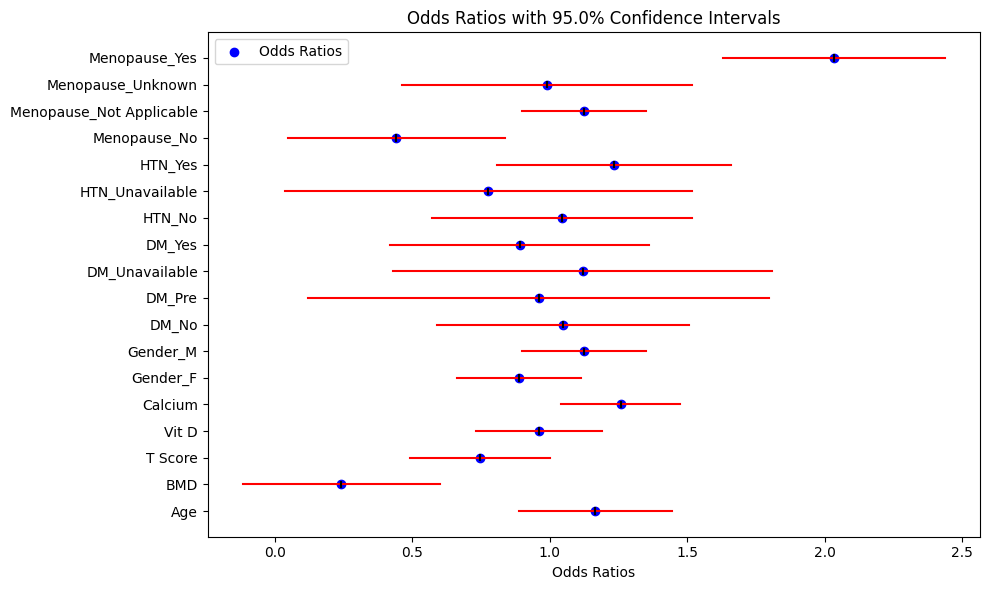

AUC for class Normal: 0.9007197621655453
AUC for class Penia: 0.6773182057542246
AUC for class Porosis: 0.7924701561065197
Overall AUC (micro-average): 0.8288658006587719


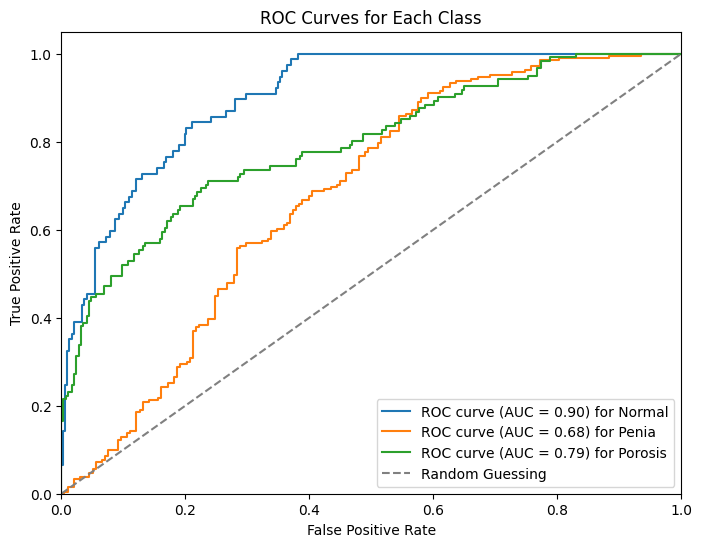

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score
from mord import LogisticAT
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

df = pd.read_csv('/content/Final_Cleaned.csv')

categorical_features = ['Gender', 'DM', 'HTN', 'Menopause']
numerical_features = ['Age', 'BMD', 'T Score', 'Vit D', 'Calcium']

#imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
#df[['Vit D', 'Calcium']] = imputer.fit_transform(df[['Vit D', 'Calcium']])

#imputer = SimpleImputer(strategy='median', missing_values=np.nan)
#df[['Vit D', 'Calcium']] = imputer.fit_transform(df[['Vit D', 'Calcium']])

knn_imputer = KNNImputer(n_neighbors=5)
cat_imputer = SimpleImputer(strategy='most_frequent')
one_hot_encoder = OneHotEncoder()

df['Diagnosis'] = pd.Categorical(df['Diagnosis'], ordered=True, categories=['Normal', 'Penia', 'Porosis'])
label_encoder = LabelEncoder()
df['Diagnosis'] = label_encoder.fit_transform(df['Diagnosis'])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', knn_imputer), ('scaler', StandardScaler())]), numerical_features),
        ('cat', Pipeline([('imputer', cat_imputer), ('onehot', one_hot_encoder)]), categorical_features),
    ]
)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', LogisticAT())
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

y_pred = cross_val_predict(pipeline, X, y, cv=cv)

accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)

pipeline.fit(X, y)
feature_names = numerical_features + list(pipeline.named_steps['preprocess'].transformers_[1][1]['onehot'].get_feature_names_out(input_features=categorical_features))

coefficients = pipeline.named_steps['model'].coef_
odds_ratios = np.exp(coefficients)
print("Odds Ratios:")
for ratio, feature_name in zip(odds_ratios, feature_names):
    print(feature_name, ":", ratio)

n_bootstraps = 1000
bootstrapped_coefs = np.zeros((n_bootstraps, len(feature_names)))
for i in range(n_bootstraps):
    bootstrap_indices = np.random.choice(len(X), size=len(X), replace=True)
    pipeline.fit(X.iloc[bootstrap_indices], y.iloc[bootstrap_indices])
    coefficients = pipeline.named_steps['model'].coef_
    bootstrapped_coefs[i, :len(coefficients)] = coefficients

std_errors = bootstrapped_coefs.std(axis=0)
confidence_level = 0.95
z_value = stats.norm.ppf((1 + confidence_level) / 2)
margin_of_error = z_value * std_errors
lower_bound = odds_ratios - margin_of_error
upper_bound = odds_ratios + margin_of_error

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(odds_ratios, range(len(odds_ratios)), color='blue', label='Odds Ratios')
for i, (lower, upper) in enumerate(zip(lower_bound, upper_bound)):
    ax.plot([lower, upper], [i, i], color='red')
    ax.plot([odds_ratios[i], odds_ratios[i]], [i - 0.1, i + 0.1], color='black')
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(feature_names)
ax.set_xlabel('Odds Ratios')
ax.set_title('Odds Ratios with {}% Confidence Intervals'.format(confidence_level * 100))
ax.legend()
plt.tight_layout()
plt.show()

y_binarized = label_binarize(y, classes=[0, 1, 2])
pipeline.fit(X, y)
y_probs = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')
auc_scores = []
for i in range(len(label_encoder.classes_)):
    auc_score = roc_auc_score(y_binarized[:, i], y_probs[:, i])
    auc_scores.append(auc_score)
    print(f"AUC for class {label_encoder.classes_[i]}: {auc_score}")

micro_auc = roc_auc_score(y_binarized, y_probs, average='micro')
print(f"Overall AUC (micro-average): {micro_auc}")

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_binarized[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f}) for {label_encoder.classes_[i]}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.show()
